# Data preporation for cascade classifier

Load the data, prepare files with positive and negative examples for training.

Unfortunately, we have not enough time to validate the trained model.

In [1]:
# <api>
import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# <api>
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [3]:
# <api>
# https://github.com/albu/albumentations
from albumentations import (ToFloat, Resize,
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose
)

In [4]:
# <api>
path = '../../airbus/'
path_train = path + 'train/'
path_test = path + 'test/'

In [5]:
from airbus_dataloader import *

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Data exploration

Import masks, add (groun truth) classification.

In [7]:
masks = pd.read_csv(str(path+'train_ship_segmentations.csv'))

In [8]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

In [10]:
masks[masks['ships'] == 1].head()

,ImageId,EncodedPixels,ships
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,1
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,1
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,1
5,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,1


Exclude small & corrupted images.

In [19]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images 


In [20]:
unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
unique_img_ids.shape

(104069, 4)

In [21]:
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(\
                            lambda c_img_id: os.stat(os.path.join(path_train, c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>40] # keep only >40kb files
ships = unique_img_ids[unique_img_ids['has_ship']==1]
no_ships = unique_img_ids[unique_img_ids['has_ship']==0].sample(frac=1)  #take only frac of empty images
files = pd.concat([ships, no_ships], axis=0)

#masks.drop(['ships'], axis=1, inplace=True)

In [22]:
no_ships.shape[0]

74814

How many images are empty and how many ships can be on an image?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc91230f358>,
      dtype=object)

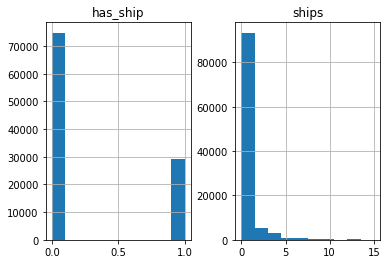

In [23]:
files[['ships', 'has_ship']].hist()

# Creating bounding boxes for the classifier

At first try it on a single example

In [24]:
ImageId = '000155de5.jpg'
image = Image.open(str(path_train + ImageId))
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

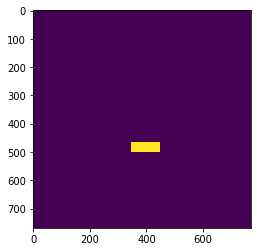

In [25]:
boxes = np.zeros((768, 768))

for mask in img_masks:
    array_mask = rle_decode(mask)
    collapse_x = array_mask.sum(axis=0)
    i = 0
    while collapse_x[i] == 0:
        i += 1
    left = i
    while (i<768) and (collapse_x[i] > 0):
        i += 1
    right = i-1
    collapse_y = array_mask.sum(axis=1)
    i = 0
    while collapse_y[i] == 0:
        i += 1
    top = i
    while i<768 and collapse_y[i] > 0:
        i += 1
    bottom = i-1
    boxes[left:right,top:bottom] = 1
    
plt.imshow(np.transpose(boxes))

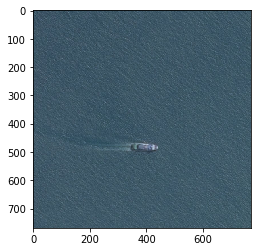

In [26]:
plt.imshow(image)

And now define a function.

In [11]:
def box_from_rle(mask):
    '''Return a box for a positive example mask.
    '''
    box = np.zeros((768, 768))
    array_mask = rle_decode(mask)
    collapse_x = array_mask.sum(axis=0)
    i = 0
    while collapse_x[i] == 0:
        i += 1
    left = i
    while (i<768) and (collapse_x[i] > 0):
        i += 1
    right = i-1
    collapse_y = array_mask.sum(axis=1)
    i = 0
    while collapse_y[i] == 0:
        i += 1
    top = i
    while i<768 and collapse_y[i] > 0:
        i += 1
    bottom = i-1
    
    height = max(bottom - top, 1)
    width = max(right - left, 1)
    center_x = left + int(width/2)
    center_y = top + int(height/2)
    return(str(center_x)+' '+ str(center_y)+ ' '+ str(width)+ ' '+ str(height)+' ')

Create boxes for all images.

In [28]:
masks['Box'] = masks['EncodedPixels'].map(lambda enc_px: box_from_rle(enc_px) if isinstance(enc_px, str) else None)

In [29]:
masks.head()

,ImageId,EncodedPixels,ships,Box
0,00003e153.jpg,NaN,0,None
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,395 482 103 35
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,1,149 746 36 29
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,1,129 760 12 11
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,1,101 717 10 4


In [30]:
masks.to_csv('masks.csv')

In [31]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
img_boxes = masks.groupby('ImageId').agg({'ships': 'sum', 'Box' : 'sum'}).reset_index()

In [32]:
img_boxes['address'] = path_train + img_boxes['ImageId']

In [33]:
img_boxes.head()

,ImageId,ships,Box,address
0,00003e153.jpg,0,0,../airbus/train/00003e153.jpg
1,000155de5.jpg,1,395 482 103 35,../airbus/train/000155de5.jpg
2,00021ddc3.jpg,9,149 746 36 29 129 760 12 11 101 717 10 4 197 6...,../airbus/train/00021ddc3.jpg
3,0002756f7.jpg,2,341 48 17 25 334 53 20 25,../airbus/train/0002756f7.jpg
4,0002d0f32.jpg,0,0,../airbus/train/0002d0f32.jpg


Separate positive and negative examles and save them into different files.

In [34]:
img_boxes_ship = img_boxes[img_boxes['ships']>0]
img_boxes_no_ship = img_boxes[img_boxes['ships']==0]

In [35]:
img_boxes_no_ship['address'].to_csv('no_ship.txt', header=False, index=False)

In [37]:
img_boxes_ship.loc[:, ['address', 'ships', 'Box']].to_csv('ships.txt', sep='\t', header=False, index=False)